In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [48]:
# read the dataset
retail_df = pd.read_csv("Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [49]:
retail_df.shape

(541909, 8)

In [50]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

## Cleaning the data

In [51]:
retail_df.isnull().sum()/len(retail_df)

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [52]:
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [53]:
retail_df['Amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head(
)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## Preparing the data for modeling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of transactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [54]:
group_df = retail_df.groupby('CustomerID')['Amount'].sum()
group_df = group_df.reset_index()
group_df.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [55]:
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [56]:
group_df = pd.merge(group_df,frequency,on= 'CustomerID', how='inner')
group_df.head()

,CustomerID,Amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [57]:
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [58]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [59]:
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [60]:
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [61]:
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()

In [62]:
group_df = pd.merge(group_df,last_purchase,on= 'CustomerID', how='inner')
group_df.columns = ['CustoemrID','Amount','Frequency','Recency']
group_df.head()

,CustoemrID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [63]:
import datetime as dt
group_df['Recency'] = group_df['Recency'].dt.days

In [64]:
group_df.head()

,CustoemrID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


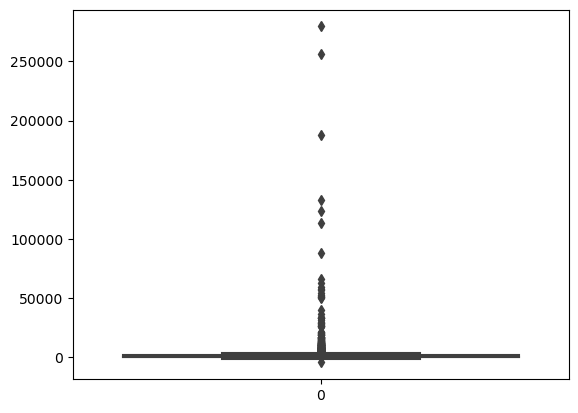

In [65]:
sns.boxplot(group_df['Amount'])
plt.show()

two types of outliers:
- statistical
- domain specific

In [66]:
Q1 = group_df.Amount.quantile(0.05)
Q3 = group_df.Amount.quantile(0.95)
IQR = Q3 - Q1
group_df = group_df[(group_df.Amount >= Q1 - 1.5*IQR) & (group_df.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = group_df.Recency.quantile(0.05)
Q3 = group_df.Recency.quantile(0.95)
IQR = Q3 - Q1
group_df = group_df[(group_df.Recency >= Q1 - 1.5*IQR) & (group_df.Recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = group_df.Frequency.quantile(0.05)
Q3 = group_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
group_df = group_df[(group_df.Frequency >= Q1 - 1.5*IQR) & (group_df.Frequency <= Q3 + 1.5*IQR)]

In [67]:
rfm_df = group_df[['Amount','Frequency','Recency']]
rfm_df.head()


,Amount,Frequency,Recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [68]:
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

Some usefull links to understand Hopkins Statistics:
- [WikiPedia](https://en.wikipedia.org/wiki/Hopkins_statistic)
- [Article](http://www.sthda.com/english/articles/29-cluster-validation-essentials/95-assessing-clustering-tendency-essentials/)

In [69]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [70]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']

In [71]:
hopkins(rfm_df_scaled)

0.9495541014133568

In [72]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [73]:
kmeans = KMeans(n_clusters= 4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [74]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2])

## Finding the optimal number of clusters

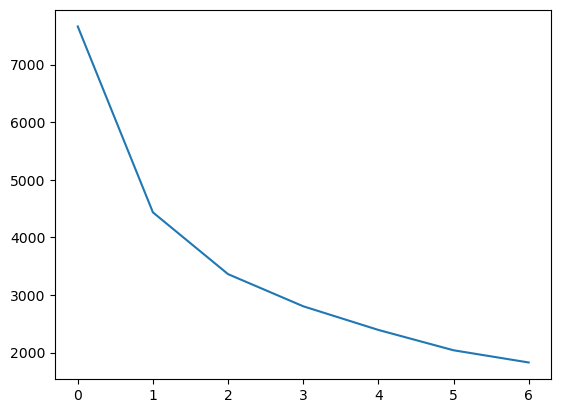

In [75]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for num in range_n_clusters:
    kmeans = KMeans(n_clusters= num, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)
plt.plot(ssd)
plt.show()

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [76]:
range_n_clusters = [2,3,4,5,6,7,8]
for num in range_n_clusters:
    kmeans = KMeans(n_clusters= num, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df_scaled,cluster_labels)
    print('For n_clusters = {0}, the silhouette score is {1}'.format(num,silhouette_avg))

For n_clusters = 2, the silhouette score is 0.5411246404292333
For n_clusters = 3, the silhouette score is 0.5084896296141937
For n_clusters = 4, the silhouette score is 0.4777820100216849
For n_clusters = 5, the silhouette score is 0.46627005641897035
For n_clusters = 6, the silhouette score is 0.41707885139850487
For n_clusters = 7, the silhouette score is 0.4167505510924605
For n_clusters = 8, the silhouette score is 0.3887713447942857


In [77]:
kmeans = KMeans(n_clusters= 3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [78]:
kmeans.labels_

array([1, 2, 0, ..., 1, 0, 0])

In [79]:
group_df['clusterId'] = kmeans.labels_
group_df.head()

,CustoemrID,Amount,Frequency,Recency,clusterId
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


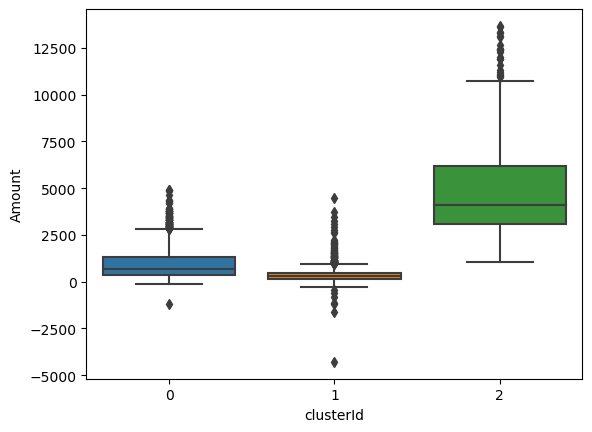

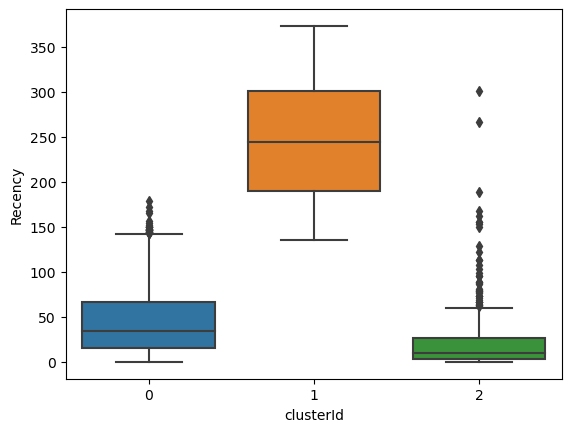

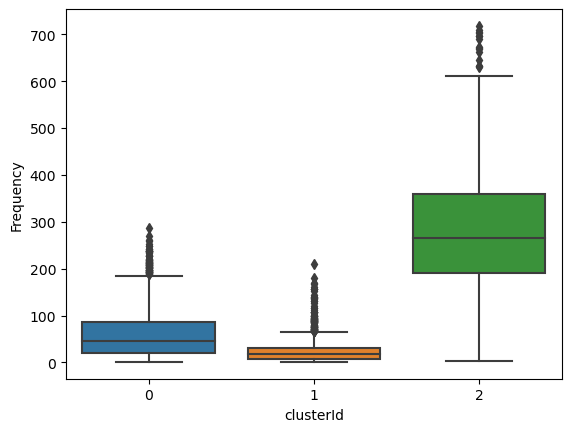

In [80]:
sns.boxplot(x = 'clusterId', y = 'Amount',data= group_df )
plt.show()
sns.boxplot(x = 'clusterId', y = 'Recency',data= group_df )
plt.show()
sns.boxplot(x = 'clusterId', y = 'Frequency',data= group_df )
plt.show()

In [81]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [82]:
group_df.head()

,CustoemrID,Amount,Frequency,Recency,clusterId
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


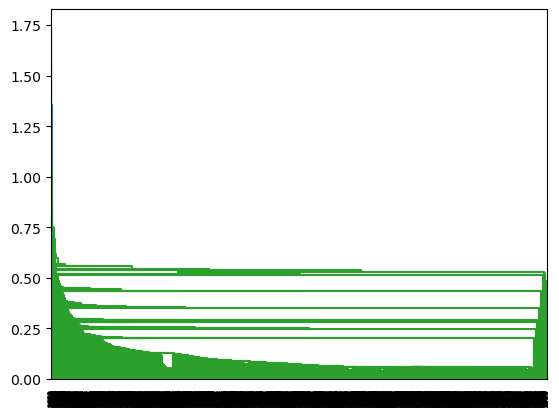

In [83]:
#single linkage
merging = linkage(rfm_df_scaled,method='single',metric= 'euclidean')
dendrogram(merging)
plt.show()

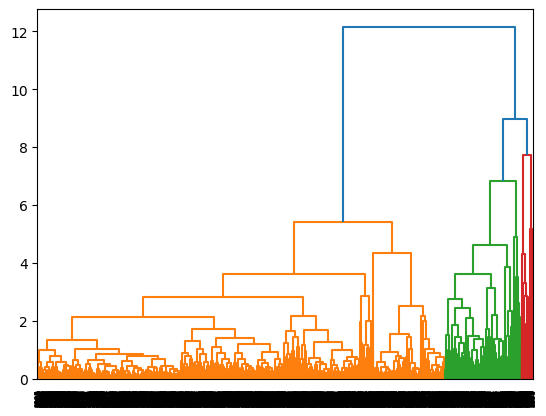

In [84]:
merging = linkage(rfm_df_scaled,method='complete',metric= 'euclidean')
dendrogram(merging)
plt.show()

In [85]:
cluster_labels = cut_tree(merging,n_clusters=3).reshape(-1,)
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [86]:
group_df['cluster_labels'] = cluster_labels
group_df.head()

,CustoemrID,Amount,Frequency,Recency,clusterId,cluster_labels
0,12346.0,0.00,2,325,1,0
1,12347.0,4310.00,182,1,2,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,1,0


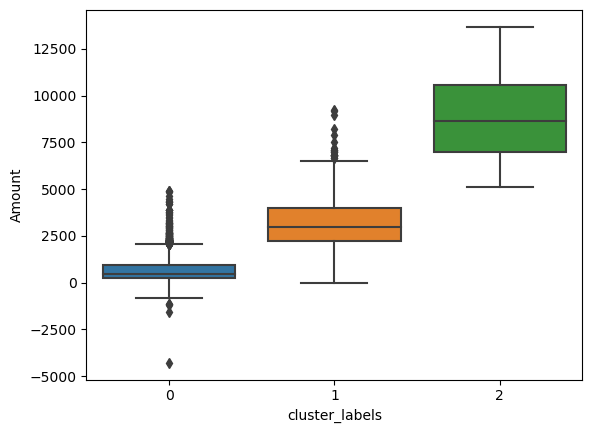

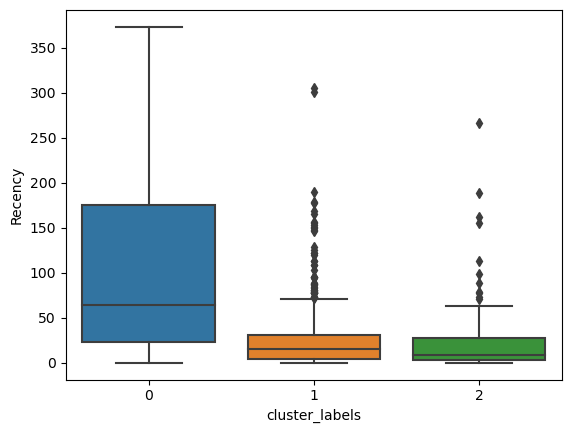

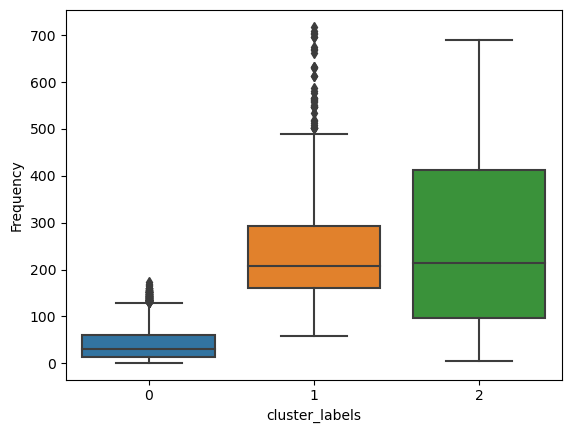

In [87]:
sns.boxplot(x = 'cluster_labels', y = 'Amount',data= group_df )
plt.show()
sns.boxplot(x = 'cluster_labels', y = 'Recency',data= group_df )
plt.show()
sns.boxplot(x = 'cluster_labels', y = 'Frequency',data= group_df )
plt.show()